In [172]:
import numpy as np
import pandas as pd
import tensorflow as tf 
import tensorflow.keras.layers as layers
from tensorflow.keras import Model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [61]:
%cd /content/drive/My Drive/projects/Deep_Learning_F20_Assignments/Assignment-02/python/Regression

/content/drive/My Drive/projects/Deep_Learning_F20_Assignments/Assignment-02/python/Regression


# Assignment Set 2
by **Amir Mehrpanah** for Deep Learing Course at Data Science Center, SBU


## Preprocessing

In [141]:
#@title Reading The Data
df = pd.read_csv('data/HRDataset.csv').drop(columns=['Employee_Name',
                                                     'ManagerName',
                                                     'Zip',
                                                     'Position',
                                                     'MaritalDesc',
                                                     'MarriedID',
                                                     'Sex',
                                                     'State',
                                                     'PerformanceScore',
                                                     'Department',
                                                     'EmploymentStatus',
                                                     'DaysLateLast30', # too many nulls
                                                     'LastPerformanceReview_Date', # too many nulls
                                                     'EmpID'])

In [ ]:
#@title Cleaning Data

# remove that yellow part!
cleandf = df.dropna(how='all')

# just one case in TermReason column majority imputing method
cleandf['TermReason'][3] = 'N/A - still employed'

# TermReason to TermReasonID
cleandf['TermReasonID'] = cleandf.pop('TermReason').astype('category').cat.codes

# HispanicLatino to category
cleandf['HispanicLatino'] =cleandf['HispanicLatino'].astype('category').cat.codes

# CitizenDesc to CitizenID
cleandf['CitizenID'] = cleandf.pop('CitizenDesc').astype('category').cat.codes

# RaceDesc to RaceID
cleandf['RaceID'] = cleandf.pop('RaceDesc').astype('category').cat.codes

# RecruitmentSource to RecruitmentSourceID
cleandf['RcrtmtSrcID'] = cleandf.pop('RecruitmentSource').astype('category').cat.codes

# dropping null ManagerID's
cleandf = cleandf.dropna(subset=['ManagerID'])

# DOB to Age
temp = cleandf.pop('DOB').str.replace(r'(\d+\/\d+)\/(\d+)', r'\1/19\2')
cleandf['Age'] = pd.to_datetime(temp, format='%m/%d/%Y')
cleandf['Age'] = (pd.to_datetime('today') - cleandf['Age']).dt.days

# DateofHire to Experience
cleandf['Experience'] =  pd.to_datetime(cleandf.pop('DateofHire'), format='%m/%d/%Y')
cleandf['Experience'] =  (max(cleandf['Experience']) - cleandf['Experience']).dt.days

# there are many null values
cleandf = cleandf.drop(columns='DateofTermination')

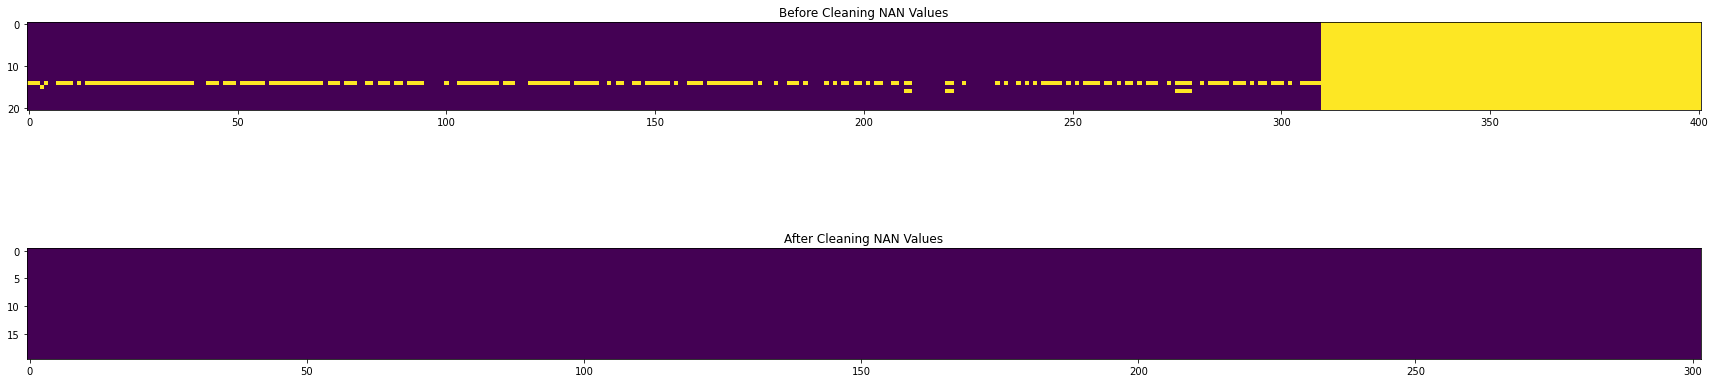

In [119]:
#@title Visualizing NAN Values

plt.figure(figsize=(30,8))

ax = plt.subplot(2,1,1)
ax.set_title('Before Cleaning NAN Values')
plt.imshow(np.array(df.isnull()).T)

ax = plt.subplot(2,1,2)
ax.set_title('After Cleaning NAN Values')

plt.imshow(np.array(cleandf.isnull()).T)
plt.show()

In [145]:
#@title OneHot Encoding 
X = cleandf.copy()
onehot_encoding_cols=['MaritalStatusID',
                      'EmpStatusID',
                      'DeptID',
                      'PositionID',
                      'ManagerID',
                      'TermReasonID',
                      'CitizenID',
                      'RaceID',
                      'RcrtmtSrcID']

for item in onehot_encoding_cols:
    temp = pd.get_dummies(X.pop(item), drop_first=True)
    X = pd.concat([temp,X],axis=1)

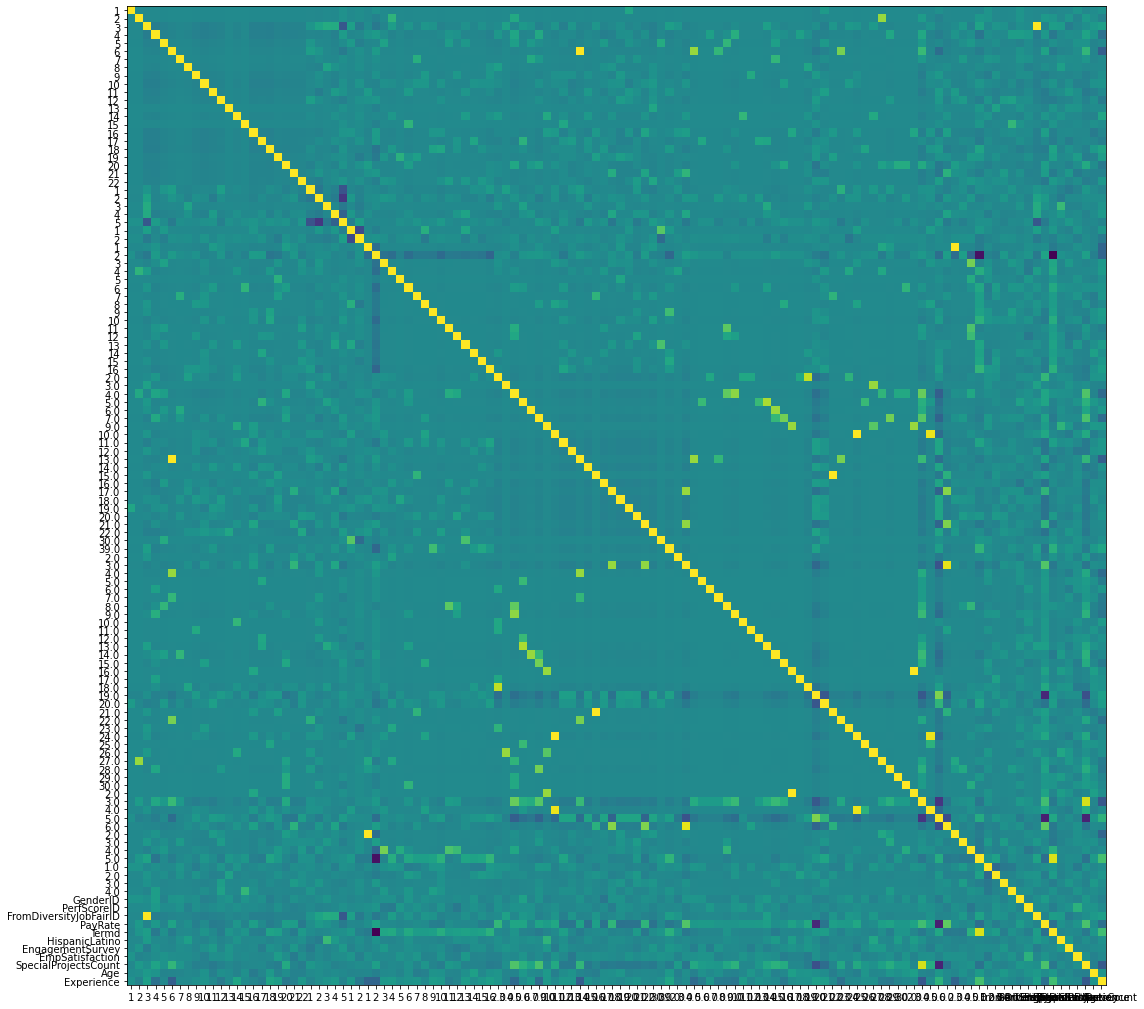

In [159]:
#@title Columns Correlation Matrix
plt.figure(figsize=(18,18))
plt.subplot(1,1,1)
cols = X.corr().columns
plt.imshow(X.corr())
plt.yticks(np.arange(0, len(cols), 1), cols)
plt.xticks(np.arange(0, len(cols), 1), cols)
plt.show()

In [162]:
#@title Train Test Split
y = X.pop('PayRate')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [163]:
#@title Performing standardization before applying PCA
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

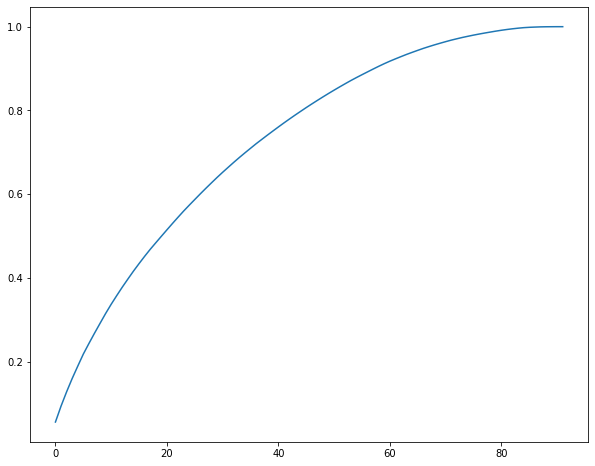

In [170]:
#@title Dimensionality Reduction Fitting PCA
plt.figure(figsize=(10,8))

pca = PCA(n_components=92)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

plt.plot(np.cumsum(pca.explained_variance_ratio_))

## Training The First Neural Network

In [243]:
inputs = layers.Input(shape=(92))
l_ = layers.Dense(64,activation='linear')(inputs)
l_ = layers.Dropout(0.1)(l_)
for i in range(8):
    
    l_ = layers.Dense(32,activation='linear')(l_)
    l_ = layers.Reshape((-1,1))(l_)
    l_ = layers.MaxPooling1D(pool_size=6,strides=2)(l_)
    l_ = layers.Flatten()(l_)
l_ = layers.Dropout(0.3)(l_)
l_ = layers.Dense(8,activation='linear')(l_)
output = layers.Dense(1)(l_)

model = Model(inputs=inputs, outputs=output)
model.compile(optimizer="Adam", loss="mse")
model.summary()

Model: "functional_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 92)]              0         
_________________________________________________________________
dense_232 (Dense)            (None, 64)                5952      
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_233 (Dense)            (None, 32)                2080      
_________________________________________________________________
reshape_170 (Reshape)        (None, 32, 1)             0         
_________________________________________________________________
max_pooling1d_170 (MaxPoolin (None, 14, 1)             0         
_________________________________________________________________
flatten_170 (Flatten)        (None, 14)              

In [ ]:
epochs = 32 #@param {type:"integer"}
model.fit(X_train, y_train, batch_size= 32,
          epochs=epochs,
          validation_data=(X_test,y_test),
          validation_batch_size=32,
          use_multiprocessing=True,
          workers=-1)

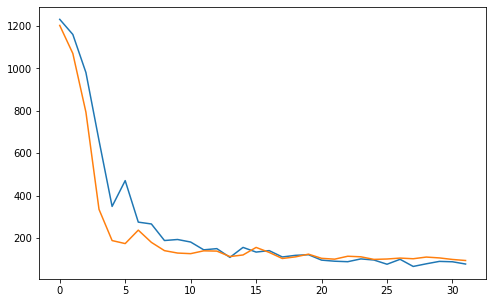

In [245]:
plt.figure(figsize=(8,5))
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])

In [246]:
np.sqrt(model.evaluate(X_test, y_test))

3/3 [==============================] - 0s 2ms/step - loss: 93.2174


9.654915035274982

## Training The Second Neural Network

In [271]:
inputs = layers.Input(shape=(92))
l_ = layers.Dense(64,activation='relu')(inputs)
l_ = layers.Dropout(0.1)(l_)
l_ = layers.Dense(32,activation='relu')(l_)
l_ = layers.Dense(16,activation='relu')(l_)
l_ = layers.Dropout(0.3)(l_)
l_ = layers.Dense(8,activation='linear')(l_)
output = layers.Dense(1)(l_)

model = Model(inputs=inputs, outputs=output)
model.compile(optimizer="Adam", loss="mse")
model.summary()

Model: "functional_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 92)]              0         
_________________________________________________________________
dense_271 (Dense)            (None, 64)                5952      
_________________________________________________________________
dropout_25 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_272 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_273 (Dense)            (None, 16)                528       
_________________________________________________________________
dropout_26 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_274 (Dense)            (None, 8)               

In [272]:
epochs = 32 #@param {type:"integer"}
model.fit(X_train, y_train, batch_size= 32,
          epochs=epochs,
          validation_data=(X_test,y_test),
          validation_batch_size=32,
          use_multiprocessing=True,
          workers=-1)

Epoch 1/32
7/7 [==============================] - 0s 18ms/step - loss: 1252.4579 - val_loss: 1227.3896
Epoch 2/32
7/7 [==============================] - 0s 4ms/step - loss: 1198.5850 - val_loss: 1179.6572
Epoch 3/32
7/7 [==============================] - 0s 4ms/step - loss: 1146.1263 - val_loss: 1138.1378
Epoch 4/32
7/7 [==============================] - 0s 4ms/step - loss: 1112.6967 - val_loss: 1094.0850
Epoch 5/32
7/7 [==============================] - 0s 4ms/step - loss: 1064.6273 - val_loss: 1040.3485
Epoch 6/32
7/7 [==============================] - 0s 4ms/step - loss: 1000.6041 - val_loss: 972.8281
Epoch 7/32
7/7 [==============================] - 0s 4ms/step - loss: 914.1263 - val_loss: 885.7029
Epoch 8/32
7/7 [==============================] - 0s 5ms/step - loss: 783.7256 - val_loss: 776.9189
Epoch 9/32
7/7 [==============================] - 0s 4ms/step - loss: 689.9622 - val_loss: 645.2672
Epoch 10/32
7/7 [==============================] - 0s 4ms/step - loss: 551.5618 - val_lo

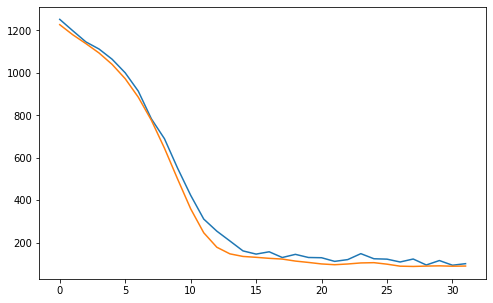

In [273]:
plt.figure(figsize=(8,5))
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])

In [274]:
np.sqrt(model.evaluate(X_test, y_test))

3/3 [==============================] - 0s 2ms/step - loss: 90.1005


9.492127620052898